<a href="https://colab.research.google.com/github/laurasculmav-maker/ELECTIVA-II_/blob/main/Tiempos_logisticos_de_mercancia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_csv("/content/Tiempos_logisticos_de_mercancia_depurado_v3.csv")  # nombre del archivo
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cargue                  1000 non-null   object 
 1   descargue               1000 non-null   object 
 2   horas_viaje             1000 non-null   float64
 3   horas_espera_cargue     1000 non-null   float64
 4   horas_espera_descargue  1000 non-null   float64
 5   horas_cargue            1000 non-null   float64
 6   horas_descargue         1000 non-null   float64
 7   valor_pagado            1000 non-null   float64
 8   cantidad                1000 non-null   float64
dtypes: float64(7), object(2)
memory usage: 70.4+ KB


In [ ]:
# 1. Crea abreviaturas para todas las ciudades

def crear_abreviatura(nombre):
    partes = nombre.split()
    abre = "".join(p[0:3].upper() for p in partes[:2])
    return abre[:6]

ciudades_unicas = pd.concat([df['cargue'], df['descargue']]).unique()

ciudad_abrebiada = {ciudad: crear_abreviatura(ciudad) for ciudad in ciudades_unicas}
abbr_to_city = {v: k for k, v in ciudad_abrebiada.items()}

# Mostrar tabla de equivalencias
print("\nTabla de equivalencias (Abreviatura → Ciudad)")
for a, c in abbr_to_city.items():
    print(f"{a}  →  {c}")


Tabla de equivalencias (Abreviatura → Ciudad)
MEDANT  →  MEDELLIN ANTIOQUIA
SABANT  →  SABANETA ANTIOQUIA
BELANT  →  BELLO ANTIOQUIA
ITAANT  →  ITAGUI ANTIOQUIA
BOGBOG  →  BOGOTA BOGOTA D. C.
LAEST  →  LA ESTRELLA ANTIOQUIA
CARBOL  →  CARTAGENA BOLIVAR
FUNCUN  →  FUNZA CUNDINAMARCA
YUMVAL  →  YUMBO VALLE DEL CAUCA
IBATOL  →  IBAGUE TOLIMA
RIOANT  →  RIONEGRO ANTIOQUIA
BUCSAN  →  BUCARAMANGA SANTANDER
TOCCUN  →  TOCANCIPA CUNDINAMARCA
DOSRIS  →  DOSQUEBRADAS RISARALDA
PERRIS  →  PEREIRA RISARALDA
CALVAL  →  CALI VALLE DEL CAUCA
CUCNOR  →  CUCUTA NORTE DE SANTANDER
BARATL  →  BARRANQUILLA ATLANTICO
CHICOR  →  CHINU CORDOBA
VILMET  →  VILLAVICENCIO META
COPANT  →  COPACABANA ANTIOQUIA
IPINAR  →  IPIALES NARINO
SEVVAL  →  SEVILLA VALLE DEL CAUCA
ZIPCUN  →  ZIPAQUIRA CUNDINAMARCA
TIMCAU  →  TIMBIO CAUCA
FLOVAL  →  FLORIDA VALLE DEL CAUCA
PUETEJ  →  PUERTO TEJADA CAUCA
CARVAL  →  CARTAGO VALLE DEL CAUCA
TURANT  →  TURBO ANTIOQUIA
PAZDE  →  PAZ DE ARIPORO CASANARE
LATEB  →  LA TEBAIDA QUINDI

In [ ]:
# 2. Selección de ciudad

ciudad = ""
print('Las ciudades de cargue son:\n', df['cargue'].unique(), '\n')

while ciudad not in df['cargue'].unique():
    ciudad = input("Digite la ciudad de ORIGEN: ")

print(f"\n Ciudad seleccionada: {ciudad}  →  {ciudad_abrebiada[ciudad]}\n")

Las ciudades de cargue son:
 ['MEDELLIN ANTIOQUIA' 'SABANETA ANTIOQUIA' 'BELLO ANTIOQUIA'
 'ITAGUI ANTIOQUIA' 'BOGOTA BOGOTA D. C.'
 'LA ESTRELLA LA ESTRELLA ANTIOQUIA' 'CARTAGENA BOLIVAR'
 'FUNZA CUNDINAMARCA' 'YUMBO VALLE DEL CAUCA' 'IBAGUE TOLIMA'
 'RIONEGRO ANTIOQUIA'] 

Digite la ciudad de ORIGEN: MEDELLIN ANTIOQUIA

 Ciudad seleccionada: MEDELLIN ANTIOQUIA  →  MEDANT



In [ ]:
# 3. Crear Peso
df['eficiencia_logistica'] = (
    df['horas_viaje'] +
    df['horas_espera_cargue'] +
    df['horas_espera_descargue'] +
    df['horas_cargue'] +
    df['horas_descargue'] +
    (df['valor_pagado'] / 600000) +
    (1 / (df['cantidad'] ))
)


> Aquí se obtiene la “eficiencia_logistica” para cada viaje tomando en cuenta varios factores.

> Cada parte aporta algo al costo final del recorrido:
>

> - **`horas_viaje`**: es el tiempo que dura el recorrido; mientras más horas, mayor será el puntaje.

> - **`horas_espera_cargue`**: son las horas que el vehículo debe esperar antes de cargar.

> - **`horas_espera_descargue`**: son las horas de espera al llegar al destino.   

> - **`horas_cargue`** y **`horas_descargue`**: son los tiempos reales de cargar y descargar.

> - **`valor_pagado / 600000`**: estos valores se dividen para que no sobresalgan demasiado frente a las horas. Se toma el valor de "600.000" para convertir la escala parecida al resto.  

> - **`(1 / (cantidad + 1)) `**: este cálculo penaliza los viajes con poca carga. Si se transporta poca cantidad, este valor aumenta y hace que el viaje se considere menos eficiente .
>
> En conjunto, todos estos elementos ayudan a obtener un puntaje que representa qué tan “costoso” o “conveniente” es cada trayecto, teniendo en cuenta no solo el tiempo, sino también el dinero y la eficiencia del transporte.


In [ ]:
# Crear el arbol de manera jerarquica
def jerarquico_pos(G, root):
    pos = {}
    layers = nx.single_source_shortest_path_length(G, root)
    orden = sorted(layers.items(), key=lambda x: x[1])

    niveles = {}
    for nodo, nivel in orden:
        niveles.setdefault(nivel, []).append(nodo)

    y_gap = 1
    x_gap = 1.2

    for nivel, nodos in niveles.items():
        x_start = - (len(nodos)-1)/2
        for i, nodo in enumerate(nodos):
            pos[nodo] = (x_start + i*x_gap, -nivel*y_gap)

    return pos


 Ruta más rápida: MEDANT:BARATL


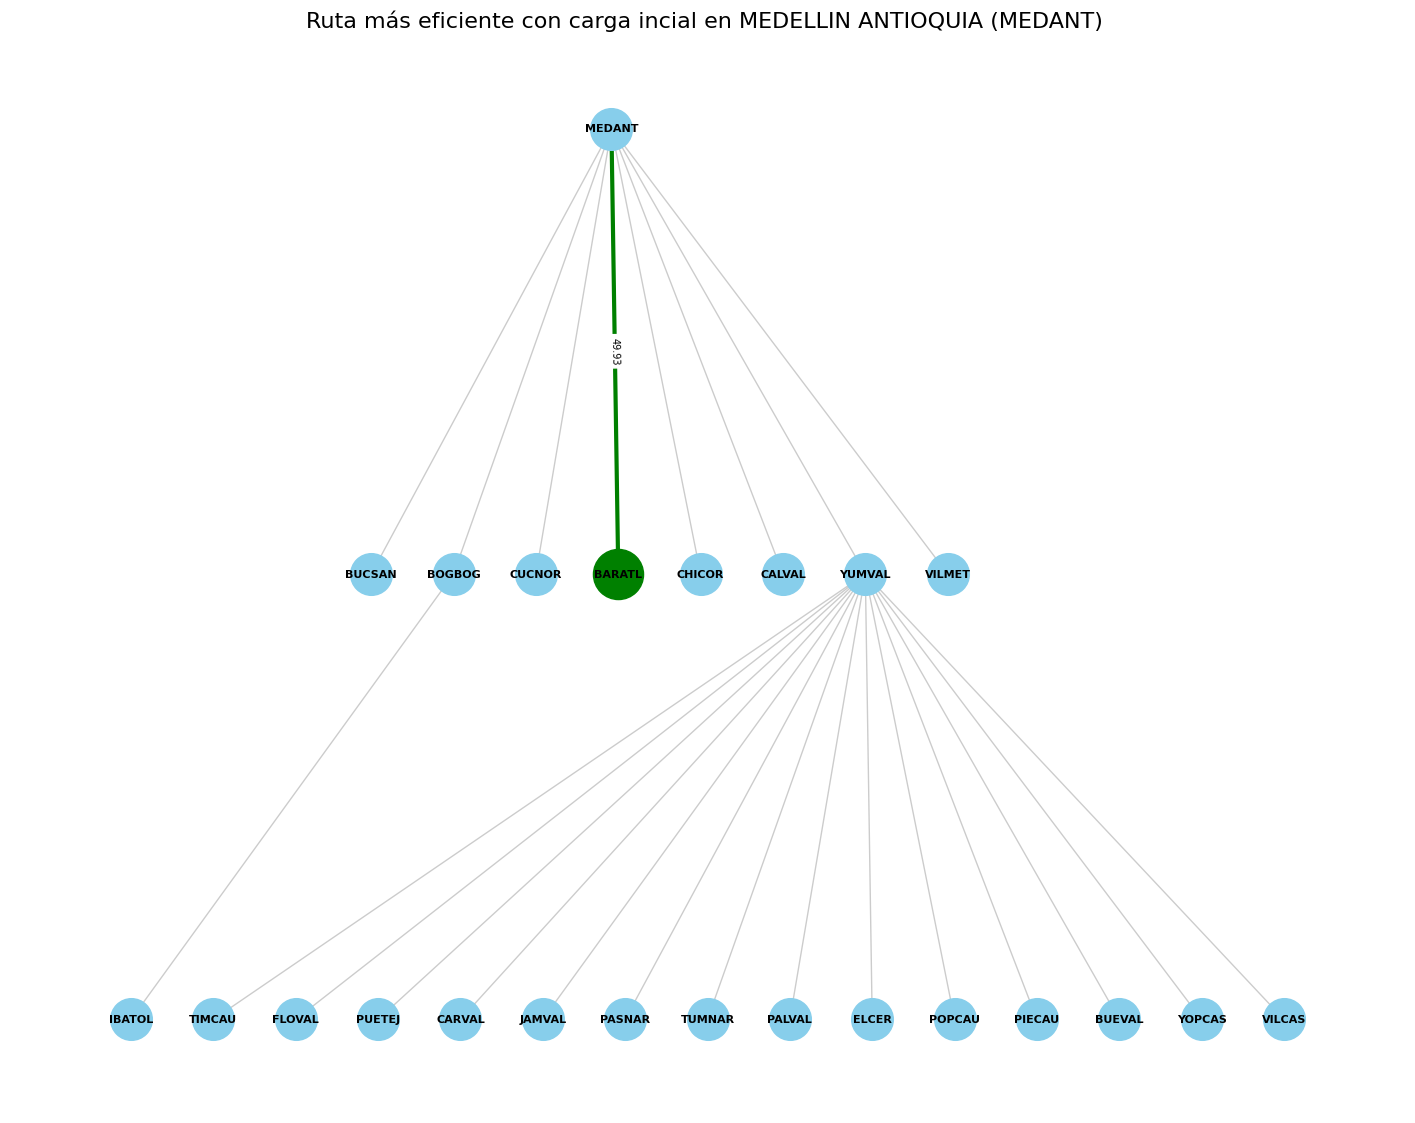

In [ ]:
# 4. Grafo

G = nx.DiGraph()

for _, row in df.iterrows():
    origen = ciudad_abrebiada[row['cargue']]
    destino = ciudad_abrebiada[row['descargue']]
    eficiencia_logistica = float(row['eficiencia_logistica'])
    G.add_edge(origen, destino, weight=eficiencia_logistica)

# 5. Árbol
root = ciudad_abrebiada[ciudad]
rutas = nx.single_source_dijkstra_path(G, root)

# Convertir rutas en aristas
aristas = []
for destino, camino in rutas.items():
    for i in range(len(camino) - 1):
        aristas.append((camino[i], camino[i+1]))

# Crear árbol dirigido
T = nx.DiGraph()
T.add_edges_from(aristas)

# 6. Cálculo de la ruta MÁS RÁPIDA hacia TODAS
distancias = nx.single_source_dijkstra_path_length(G, root)

#Excluir el propio nodo raíz
distancias_sin_raiz = {n: d for n, d in distancias.items() if n != root}

# ruta más rapida
if distancias_sin_raiz:
    destino_mas_rapido = min(distancias_sin_raiz, key=distancias_sin_raiz.get)
    ruta_rapida = nx.dijkstra_path(G, root, destino_mas_rapido)
    print("\n Ruta más rápida:", ":".join(ruta_rapida))

# Crear lista de aristas de la ruta rápida
aristas_ruta_rapida = [(ruta_rapida[i], ruta_rapida[i+1]) for i in range(len(ruta_rapida)-1)]

# 7. Visualización con ruta marcada
plt.figure(figsize=(18, 14))

pos = jerarquico_pos(T, root)

# Dibujar aristas normales
nx.draw_networkx_edges(T, pos, edge_color="gray", arrows=True, alpha=0.4)

# Dibujar arista de la ruta más rápida
nx.draw_networkx_edges(
    T, pos,
    edgelist=aristas_ruta_rapida,
    width=3,
    edge_color="green",
    arrows=True
)

# Colorear nodos normales
nx.draw_networkx_nodes(T, pos, node_size=900, node_color="skyblue")

# Resaltar nodo final
nx.draw_networkx_nodes(T, pos, nodelist=[destino_mas_rapido], node_size=1300, node_color="green")

# Dibujar labels de nodos
nx.draw_networkx_labels(T, pos, font_size=8, font_weight="bold")

# 8. Mostrar tiempos en cada arista
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in aristas_ruta_rapida}
nx.draw_networkx_edge_labels(T, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

plt.title(f"Ruta más eficiente con carga incial en {ciudad} ({root}) ", fontsize=16)
plt.axis('off')
plt.show()



In [ ]:
# Crear una lista con todos los destinos y sus pesos
rutas_ordenadas = sorted(distancias.items(), key=lambda x: x[1])

print("\n Rutas más cortas concarga desde", ciudad, f"({root}) ===")
for destino, eficiencia_logistica in rutas_ordenadas:
    if destino == root:
        continue  # omitimos la raíz
    ruta = " → ".join(rutas[destino])
    print(f"{ruta:<50} | eficiencia_logistica = {eficiencia_logistica:.2f}")



 Rutas más cortas concarga desde MEDELLIN ANTIOQUIA (MEDANT) ===
MEDANT → BARATL                                    | eficiencia_logistica = 49.93
MEDANT → CALVAL                                    | eficiencia_logistica = 49.96
MEDANT → BOGBOG                                    | eficiencia_logistica = 49.96
MEDANT → CHICOR                                    | eficiencia_logistica = 49.97
MEDANT → CUCNOR                                    | eficiencia_logistica = 49.98
MEDANT → YUMVAL                                    | eficiencia_logistica = 49.99
MEDANT → BUCSAN                                    | eficiencia_logistica = 50.79
MEDANT → VILMET                                    | eficiencia_logistica = 50.96
MEDANT → YUMVAL → JAMVAL                           | eficiencia_logistica = 68.83
MEDANT → YUMVAL → BUEVAL                           | eficiencia_logistica = 73.43
MEDANT → YUMVAL → FLOVAL                           | eficiencia_logistica = 74.39
MEDANT → YUMVAL → CARVAL        